In [1]:
# a great deal of credit goes to @Deryck_SG's nflfastR Python Guide: https://gist.github.com/Deryck97/dff8d33e9f841568201a2a0d5519ac5e

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_colwidth', -1)

In [2]:
# https://github.com/guga31bb/nflfastR-data/tree/master/data
# merged 2000-2009 and 2010-2019 into two large csv.gz files
data_00s = pd.read_csv('pbp_data/play_by_play_2000s.csv.gz', compression='gzip', low_memory=False)
data_10s = pd.read_csv('pbp_data/play_by_play_2010s.csv.gz', compression='gzip', low_memory=False)
data = pd.concat([data_00s, data_10s])

In [3]:
# https://github.com/guga31bb/nflfastR-data/tree/master/roster-data
roster_data = pd.read_csv('roster.csv.gz', compression='gzip', low_memory=False)

In [4]:
# return a DataFrame with all corresponding regular season play by play data (non-sack, pass plays only);
# optional arguments allow for filtering by season(s), week(s), downs, and aDOT 
def narrow_data(data, team='', start_year=0, end_year=0, years=[], through_week=0, after_week=0, weeks=[], downs=[1,2,3,4], min_adot=None, max_adot=None):
    df = data.loc[data['pass_attempt']==1]    
    df = df.loc[df.season_type=='REG']
    df = df.loc[df['down'].isin(downs)]
    if team != '':
        df = df.loc[df['posteam']==team]
    if years != []:
        df = df.loc[df['year'].isin(years)]
    if start_year > 0:
        df = df.loc[df['year'] >= start_year]
    if end_year > 0:
        df = df.loc[df['year'] <= end_year]
    if weeks != []:
        df = df.loc[df['week'].isin(weeks)]
    if through_week > 0:
        df = df.loc[df['week'] <= through_week]
    if after_week > 0:
        df = df.loc[df['week'] > after_week]
    if min_adot != None:
        df = df.loc[df['air_yards'] >= min_adot]
    if max_adot != None:
        df = df.loc[df['air_yards'] <= max_adot]
    return df

# given a year (and optionally,filtering by weeks as well) return a DataFrame
# with receiving data (EPA per team attempt, yards per team attempt, and target share) for each receiver, as
# well as data about that receiver's offense (the offense's EPA/play on pass plays and their total # of pass attempts)
def receiver_data(data, team='', start_year=0, end_year=0, years=[], through_week=0, after_week=0, weeks=[], downs=[1,2,3,4], min_adot=None, max_adot=None):
    df = narrow_data(data, team=team, start_year=start_year, end_year=end_year, years=years, through_week=through_week, after_week=after_week, weeks=weeks, downs=downs, min_adot=min_adot, max_adot=max_adot)
    receivers = df.groupby(['receiver_id','posteam', 'year'], as_index=False).agg({'epa':'sum', 'yards_gained':'sum', 'air_yards': 'sum', 'pass_attempt':'count', 'success':'mean'})
    receivers = receivers.merge(roster_data[['teamPlayers.displayName','teamPlayers.gsisId','team.season', 'teamPlayers.position']], left_on=['receiver_id','year'], right_on=['teamPlayers.gsisId','team.season']).drop(['teamPlayers.gsisId', 'team.season'], axis=1)
    receivers.rename(columns={'teamPlayers.displayName':'receiver', 'teamPlayers.position':'position','posteam':'team', 'pass_attempt':'targets', 'yards_gained':'yards', 'success':'success_rate'}, inplace=True)
    posteam_agg = df.groupby(['posteam', 'year']).agg({'pass':'sum', 'epa':'mean', 'yards':'mean'})
    posteam_agg.rename(columns={'epa':'team_epa/play', 'yards':'team_yards/play', 'pass':'team_atts'}, inplace=True)
    receivers = receivers.merge(posteam_agg, left_on=['team', 'year'], right_on=['posteam', 'year'])  
    receivers['epa/team_atts'] = receivers['epa']/receivers['team_atts']
    receivers['yards/team_atts'] = receivers['yards']/receivers['team_atts']
    receivers['air_yards/team_atts'] = receivers['air_yards']/receivers['team_atts']
    receivers['target_share'] = receivers['targets']/receivers['team_atts']
    column_order = ['receiver_id', 'position', 'year', 'receiver', 'team', 'epa/team_atts', 'yards/team_atts', 'air_yards/team_atts', 'success_rate', 'target_share', 'epa','yards', 'targets', 'team_atts', 'team_epa/play', 'team_yards/play', 'team_success_rate']
    receivers = receivers.reindex(columns=column_order)
    return receivers

In [5]:
# given receiver_data df, calculate year-to-year correlation for both yards per team att and epa per team att
# code "borrowed" and repurposed from https://github.com/ArrowheadAnalytics/nfl_analyses/blob/master/year_over_year_corr.ipynb courtesy of @ArrowheadAnalytics
def year_to_year_corr(receivers):
    columns = ['receiver_id', 'year', 'team', 'epa/team_atts', 'epa', 'success_rate', 'yards/team_atts', 'air_yards/team_atts', 'yards', 'target_share','targets', 'team_epa/play', 'team_yards/play']
    receivers = receivers[columns]
    receivers = receivers.loc[receivers['targets'] >= 43] # 5 targets * 17 weeks / 2, as per nfl next gen stats
    receivers = receivers[receivers.groupby('receiver_id').receiver_id.transform('count') > 1]
    lreceivers = receivers.groupby(by='receiver_id').shift(-1)
    receivers.columns = ['receiver_id', 'prev_year', 'prev_team', 'prev_epa/team_atts', 'prev_epa', 'prev_success_rate', 'prev_yards/team_atts', 'prev_air_yards/team_atts', 'prev_yards', 'prev_target_share','prev_targets', 'prev_team_epa/play', 'prev_team_yards/play']
    new_receivers = pd.concat((receivers, lreceivers), axis=1).dropna(subset=['year'])
    corr = new_receivers.corr(method='pearson')
    return corr

corr = year_to_year_corr(receiver_data(data, start_year=2007))
predictiveness = corr.iloc[1:11, 12:22]

# table formatting

def format_col_name(col_name):
    new_col_name = col_name
    replacements = {
                'epa':'EPA',
                'team_atts':'TPA',
                '_':' ',
                'yards':'Yds'
               }
    for original, new in replacements.items():
        new_col_name = new_col_name.replace(original,new)
    new_col_name = new_col_name.title().replace('Epa', 'EPA').replace('Tpa','TPA')
    return new_col_name

def format_df(df, round_decimal=2):
    new_cols = {col:format_col_name(col) for col in list(df.columns)}
    try:
        new_index = {row:format_col_name(row) for row in list(df.index)}
        new_df = df.rename(columns=new_cols, index=new_index)
    except AttributeError: # in case of int index
        new_df = df.rename(columns=new_cols)
    return new_df.round(decimals=round_decimal)

format_df(predictiveness)#.to_html().replace('\n', '')

,EPA/TPA,EPA,Success Rate,Yds/TPA,Air Yds/TPA,Yds,Target Share,Targets,Team EPA/Play,Team Yds/Play
Prev EPA/TPA,0.34,0.35,0.27,0.36,0.34,0.39,0.31,0.34,0.21,0.18
Prev EPA,0.35,0.37,0.28,0.37,0.34,0.40,0.32,0.35,0.22,0.19
Prev Success Rate,0.27,0.28,0.35,0.20,0.15,0.22,0.15,0.18,0.20,0.18
Prev Yds/TPA,0.33,0.34,0.20,0.53,0.57,0.53,0.52,0.52,0.08,0.06
Prev Air Yds/TPA,0.29,0.30,0.15,0.53,0.76,0.53,0.50,0.48,-0.00,-0.00
Prev Yds,0.35,0.36,0.21,0.53,0.56,0.55,0.51,0.53,0.12,0.09
Prev Target Share,0.27,0.27,0.14,0.50,0.52,0.49,0.54,0.52,0.02,-0.00
Prev Targets,0.29,0.30,0.16,0.49,0.50,0.50,0.52,0.53,0.06,0.03
Prev Team EPA/Play,0.21,0.23,0.23,0.07,-0.01,0.12,0.01,0.07,0.34,0.31
Prev Team Yds/Play,0.17,0.19,0.19,0.07,0.00,0.12,0.01,0.06,0.31,0.31


In [6]:
eff_corr = corr.iloc[12:20,20:].sort_values('team_epa/play', ascending=False) # how well each metric correlates with team offensive efficiency
format_df(eff_corr)#.to_html().replace('\n', '')

,Team EPA/Play,Team Yds/Play
EPA,0.54,0.49
EPA/TPA,0.53,0.49
Success Rate,0.48,0.46
Yds,0.25,0.26
Yds/TPA,0.21,0.24
Targets,0.10,0.08
Target Share,0.05,0.06
Air Yds/TPA,0.02,0.05


In [7]:
metric_df = pd.DataFrame()
metric_df['metric'] = pd.Series(corr.columns[12:20])
metric_df['stability'] = metric_df['metric'].apply(lambda metric: corr[metric]['prev_'+metric])
metric_df['efficiency_correlation'] = metric_df['metric'].apply(lambda metric: corr[metric]['team_epa/play'])
metric_df.index = metric_df['metric']
metric_df.drop('metric',axis=1, inplace=True)

format_df(metric_df.sort_values('efficiency_correlation', ascending=False))#.to_html().replace('\n','')

,Stability,Efficiency Correlation
metric,,
EPA,0.37,0.54
EPA/TPA,0.34,0.53
Success Rate,0.35,0.48
Yds,0.55,0.25
Yds/TPA,0.53,0.21
Targets,0.53,0.10
Target Share,0.54,0.05
Air Yds/TPA,0.76,0.02


In [8]:
# top 20 receivers of 2019 by EPA vs EPA/TPA: 

top_epa_2019 = receiver_data(data, years=[2019]).sort_values('epa',ascending=False)[:20][['receiver', 'epa']]
top_epa_2019.index = np.arange(1, len(top_epa_2019)+1)
top_epa_2019.rename(columns={'receiver':'top receivers by EPA'}, inplace=True)

top_epa_per_team_att_2019 = receiver_data(data, years=[2019]).sort_values('epa/team_atts',ascending=False)[:20][['receiver', 'epa/team_atts']]
top_epa_per_team_att_2019.index = np.arange(1, len(top_epa_per_team_att_2019)+1)
top_epa_2019['top receivers by EPA/TPA'] = top_epa_per_team_att_2019['receiver']
top_epa_2019['EPA/TPA'] = top_epa_per_team_att_2019['epa/team_atts']

format_df(top_epa_2019, round_decimal=3)#.to_html().replace('\n','')

,Top Receivers By EPA,EPA,Top Receivers By EPA/TPA,EPA/TPA
1,Michael Thomas,114.223,Michael Thomas,0.190
2,Chris Godwin,82.188,Chris Godwin,0.122
3,Julio Jones,73.149,George Kittle,0.114
4,Travis Kelce,65.997,Travis Kelce,0.110
5,Cooper Kupp,65.876,Stefon Diggs,0.110
6,Tyler Lockett,61.538,Tyler Lockett,0.109
7,Courtland Sutton,58.543,Courtland Sutton,0.108
8,George Kittle,58.414,Cooper Kupp,0.101
9,DeAndre Hopkins,58.137,Julio Jones,0.100
10,Amari Cooper,56.698,DeAndre Hopkins,0.100


In [9]:
columns = ['receiver','team','epa/team_atts','epa','success_rate','yards','yards/team_atts','air_yards/team_atts','targets','target_share']

In [10]:
top_10_epa_tpa_2019 = receiver_data(data, years=[2019]).sort_values('epa/team_atts',ascending=False)[:10][columns]
top_10_epa_tpa_2019.index = np.arange(1, len(top_10_epa_tpa_2019)+1)
format_df(top_10_epa_tpa_2019, round_decimal=3)#.to_html().replace('\n','')

,Receiver,Team,EPA/TPA,EPA,Success Rate,Yds,Yds/TPA,Air Yds/TPA,Targets,Target Share
1,Michael Thomas,NO,0.190,114.223,0.690,1725.0,2.870,2.491,185,0.308
2,Chris Godwin,TB,0.122,82.188,0.620,1333.0,1.975,1.877,121,0.179
3,George Kittle,SF,0.114,58.414,0.613,1053.0,2.057,1.236,107,0.209
4,Travis Kelce,KC,0.110,65.997,0.615,1219.0,2.032,2.020,135,0.225
5,Stefon Diggs,MIN,0.110,54.186,0.564,1130.0,2.287,2.858,95,0.192
6,Tyler Lockett,SEA,0.109,61.538,0.636,1057.0,1.881,2.440,110,0.196
7,Courtland Sutton,DEN,0.108,58.543,0.500,1112.0,2.044,2.640,124,0.228
8,Cooper Kupp,LA,0.101,65.876,0.530,1161.0,1.778,1.485,134,0.205
9,Julio Jones,ATL,0.100,73.149,0.548,1394.0,1.907,2.674,157,0.215
10,DeAndre Hopkins,HOU,0.100,58.137,0.567,1165.0,2.005,2.611,150,0.258


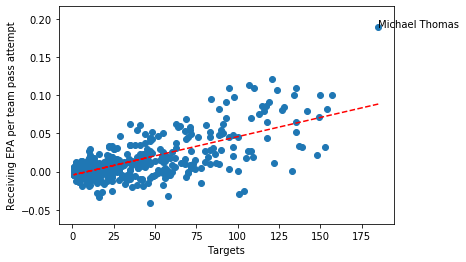

In [11]:
def plot_targets_v_epa_per_tpa(years, highlighted_receivers=[]):
    receivers = receiver_data(data, years=years).sort_values('epa/team_atts',ascending=False)
    x = receivers['targets']
    y = receivers['epa/team_atts']

    fix, ax = plt.subplots()
    ax.scatter(x, y)
    for i, name in enumerate(receivers['receiver']):
        if name in highlighted_receivers:
            ax.annotate(name, (x.iloc[i], y.iloc[i]))

    z = np.polyfit(x,y,1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"r--")

    plt.xlabel('Targets')
    plt.ylabel('Receiving EPA per team pass attempt')

plot_targets_v_epa_per_tpa([2019], highlighted_receivers=["Michael Thomas"])

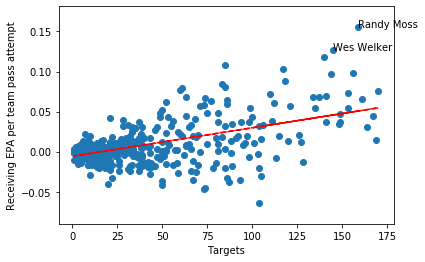

In [12]:
# fun fact: in 2007, the Patriots had the top *two* receivers by EPA/TPA. Crazy shit, right?
plot_targets_v_epa_per_tpa([2007], highlighted_receivers=["Randy Moss", "Wes Welker"])

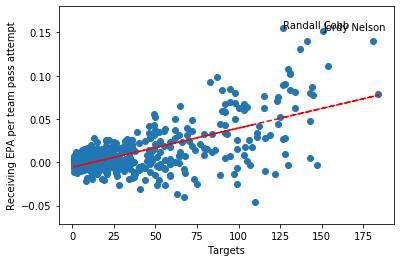

In [14]:
# The 2014 Packers pulled it off with Randall Cobb and Jordy Nelson as well.
plot_targets_v_epa_per_tpa([2014], highlighted_receivers=["Randall Cobb", "Jordy Nelson"])

In [15]:
# find the epa/team_atts leader of a given year 
def get_best_receiver_of_year(data, year):
    return receiver_data(data, years=[year]).sort_values('epa/team_atts', ascending=False).iloc[0]

# generate an HTML table with each year's epa/team_att leader since '00 (takes ~30s to calculate)
millenium_leaders = pd.Series(data.year.unique()).apply(lambda row: get_best_receiver_of_year(data, row))

In [16]:
multiyr_columns = ['year'] + columns
format_df(millenium_leaders.sort_values('year', ascending=False)[multiyr_columns], round_decimal=3)#.to_html().replace('\n','')

,Year,Receiver,Team,EPA/TPA,EPA,Success Rate,Yds,Yds/TPA,Air Yds/TPA,Targets,Target Share
19,2019,Michael Thomas,NO,0.190,114.223,0.690,1725.0,2.870,2.491,185,0.308
18,2018,Michael Thomas,NO,0.164,88.635,0.667,1405.0,2.607,2.104,147,0.273
17,2017,Michael Thomas,NO,0.128,70.530,0.595,1245.0,2.251,2.564,149,0.269
16,2016,Travis Kelce,KC,0.131,75.652,0.615,1125.0,1.950,1.360,117,0.203
15,2015,Julio Jones,ATL,0.154,100.675,0.532,1871.0,2.865,3.156,203,0.311
14,2014,Randall Cobb,GB,0.155,87.685,0.606,1287.0,2.274,2.005,127,0.224
13,2013,Anquan Boldin,SF,0.192,87.635,0.612,1179.0,2.586,2.697,129,0.283
12,2012,Michael Crabtree,SF,0.138,65.630,0.595,1105.0,2.317,1.998,126,0.264
11,2011,Rob Gronkowski,NE,0.150,96.274,0.637,1327.0,2.064,1.784,124,0.193
10,2010,Mike Wallace,PIT,0.117,59.860,0.535,1257.0,2.450,3.008,99,0.193


In [17]:
adot_columns = ['position'] + columns + ['team_atts']

In [18]:
# 5 most productive receivers on screens 
#(only looking at base downs to eliminate penalty for cowardly OCs calling 3rd and long screens)
screens = receiver_data(data, years=[2019], max_adot=0, downs=[1,2]).sort_values('epa/team_atts', ascending=False)[:5]
format_df(screens[adot_columns], round_decimal=3)#.to_html(index=False).replace('\n','')

,Position,Receiver,Team,EPA/TPA,EPA,Success Rate,Yds,Yds/TPA,Air Yds/TPA,Targets,Target Share,TPA
231,RB,Dalvin Cook,MIN,0.162,15.191,0.556,339.0,3.606,-1.351,36,0.383,94
215,RB,Mark Ingram,BAL,0.148,8.588,0.727,96.0,1.655,-0.483,11,0.190,58
111,RB,Christian McCaffrey,CAR,0.118,12.959,0.565,401.0,3.645,-1.564,62,0.564,110
273,RB,Austin Ekeler,LAC,0.109,11.459,0.558,328.0,3.124,-1.238,43,0.410,105
77,RB,Derrick Henry,TEN,0.098,6.364,0.450,184.0,2.831,-0.954,20,0.308,65


In [19]:
# 5 most productive receivers on throws going between 1 and 9 yards in the air
shorts  = receiver_data(data, years=[2019], min_adot=1, max_adot=9).sort_values('epa/team_atts', ascending=False)[:5]
format_df(shorts[adot_columns], round_decimal=3)#.to_html(index=False).replace('\n','')

,Position,Receiver,Team,EPA/TPA,EPA,Success Rate,Yds,Yds/TPA,Air Yds/TPA,Targets,Target Share,TPA
126,WR,Michael Thomas,NO,0.186,53.619,0.725,820.0,2.847,1.819,109,0.378,288
339,WR,DeAndre Hopkins,HOU,0.130,34.228,0.671,469.0,1.777,1.269,73,0.277,264
140,RB,Christian McCaffrey,CAR,0.120,32.748,0.617,459.0,1.681,0.670,60,0.220,273
307,WR,T.Y. Hilton,IND,0.116,28.149,0.700,231.0,0.955,0.661,30,0.124,242
196,TE,George Kittle,SF,0.107,23.303,0.627,454.0,2.083,1.216,52,0.239,218


In [20]:
# 5 most productive receivers on throws going between 10 and 19 yards in the air
intermediates  = receiver_data(data, years=[2019], min_adot=10, max_adot=19).sort_values('epa/team_atts', ascending=False)[:5]
format_df(intermediates[adot_columns], round_decimal=3)#.to_html(index=False).replace('\n','')

,Position,Receiver,Team,EPA/TPA,EPA,Success Rate,Yds,Yds/TPA,Air Yds/TPA,Targets,Target Share,TPA
241,WR,Tyrell Williams,LV,0.534,48.566,0.852,483.0,5.308,4.440,27,0.297,91
76,WR,Michael Thomas,NO,0.391,44.979,0.673,639.0,5.557,6.826,56,0.487,115
206,WR,Keenan Allen,LAC,0.349,49.595,0.729,594.0,4.183,4.803,48,0.338,142
189,TE,Mark Andrews,BAL,0.334,26.377,0.536,363.0,4.595,5.165,28,0.354,79
343,WR,Chris Godwin,TB,0.298,48.256,0.718,543.0,3.352,3.265,39,0.241,162


In [21]:
# 5 most productive receivers on throws going 20+ yards in the air
deeps  = receiver_data(data, years=[2019], min_adot=20).sort_values('epa/team_atts', ascending=False)[:5]
format_df(deeps[adot_columns], round_decimal=3)#.to_html(index=False).replace('\n','')

,Position,Receiver,Team,EPA/TPA,EPA,Success Rate,Yds,Yds/TPA,Air Yds/TPA,Targets,Target Share,TPA
177,WR,Stefon Diggs,MIN,0.669,43.491,0.536,624.0,9.600,14.631,28,0.431,65
111,WR,Courtland Sutton,DEN,0.427,21.794,0.478,427.0,8.373,12.510,23,0.451,51
316,WR,D.J. Chark,JAX,0.388,26.016,0.500,424.0,6.328,11.164,26,0.388,67
62,WR,A.J. Brown,TEN,0.372,20.100,0.471,378.0,7.000,9.926,17,0.315,54
67,WR,Michael Thomas,NO,0.358,16.843,0.778,229.0,4.872,4.638,9,0.191,47
